In [296]:
import nasdaqdatalink  # conda install nasdaq-data-link
import yahoo_fin.stock_info as yf  # conda install yahoo_fin

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, HuberRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, TimeSeriesSplit

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model  # pip install arch

import warnings
warnings.simplefilter("ignore")

plt.rcParams.update({'figure.figsize': (10, 6), 'figure.dpi': 80}) # set fig size

## Data gathering and processing 

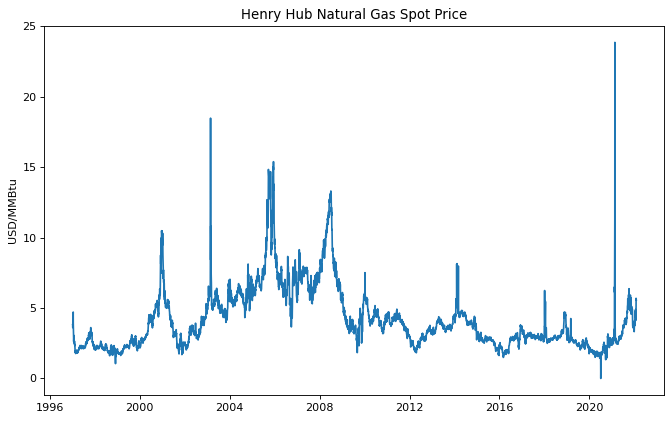

In [3]:
HH_spot_price = nasdaqdatalink.get('EIA/NG_RNGWHHD_D', 
                                   start_date='1997-01-07', 
                                   end_date='2022-01-31', 
                                   authtoken='Gymx-B5owcdhypB7ydu8')
plt.plot(HH_spot_price)
plt.title('Henry Hub Natural Gas Spot Price')
plt.ylabel('USD/MMBtu')
plt.show()

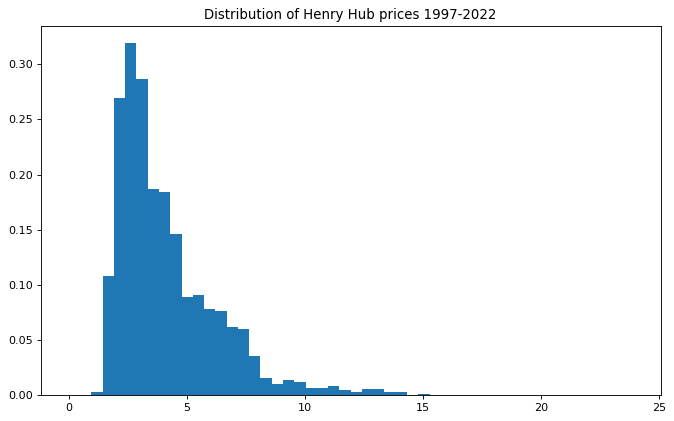

In [4]:
plt.hist(HH_spot_price, bins=50, density=True)
plt.title('Distribution of Henry Hub prices 1997-2022')
plt.show()

In [163]:
def get_datasets(source, startdate='1997-01-01', enddate='2021-12-31', auth="Gymx-B5owcdhypB7ydu8"):
    try:
        return nasdaqdatalink.get(source, start_date=startdate, end_date=enddate, authtoken=auth)
    except:
        return yf.get_data(source, start_date=startdate, end_date=enddate, interval='1mo')['adjclose'].to_frame()

features = [
  'US_gas_consumption',
  'US_gas_supply',
  'US_storage_volume',
  'US_gas_exports',
  'US_gas_imports',
  'gas_rig_count',
  'gas_marketed_production',
  'WTI_spot_price',
  #'US_PMI',  missing values
  'US_CPI',
  'dow_jones',
  '3m_treasury',
  '5y_treasury',
  #'USD/EUR'  missing values
]

API_mapping = {
    'HH_spot_price':'EIA/NG_RNGWHHD_M',
    'US_gas_consumption':'EIA/STEO_NGTCPUS_M',
    'US_gas_supply':'EIA/STEO_NGPSUPP_M',
    'US_storage_volume':'EIA/NG_N5030US2_M',
    'US_gas_exports':'EIA/NG_N9130US2_M',
    'US_gas_imports':'EIA/NG_N9100US2_M',
    'gas_rig_count':'EIA/NG_E_ERTRRG_XR0_NUS_C_M',
    'gas_marketed_production':'EIA/STEO_NGMPPUS_M',
    'WTI_spot_price':'EIA/PET_RWTC_M',
    'US_PMI':'FRED/NAPM',
    'US_CPI':'RATEINF/CPI_USA',
    'dow_jones':'^DJI',
    '3m_treasury':'^IRX',
    '5y_treasury':'^FVX',
    'USD/EUR':'EUR=X'
}

In [164]:
df = pd.DataFrame()  # contains all features indexed by date
for feature in features:
    data = get_datasets(API_mapping[feature])
    df = pd.concat([df, data], axis=1, join='outer')
df = df.set_axis(features, axis=1)  # rename the columns to match the features
df = df.resample('M').mean()  # align monthly indices
df

,US_gas_consumption,US_gas_supply,US_storage_volume,US_gas_exports,US_gas_imports,gas_rig_count,gas_marketed_production,WTI_spot_price,US_CPI,dow_jones,3m_treasury,5y_treasury
1997-01-31,81.946492,84.198499,5843054.0,12028.0,278288.0,478.0,54.851923,25.13,159.100,6813.089844,5.010,6.250
1997-02-28,81.200033,74.303301,5481074.0,12443.0,240545.0,492.0,55.022983,22.18,159.600,6877.740234,5.070,6.368
1997-03-31,69.557141,65.940162,5335550.0,16276.0,256985.0,518.0,55.180090,20.97,160.000,6583.479980,5.170,6.759
1997-04-30,61.401220,57.639494,5393231.0,13872.0,238178.0,526.0,54.345237,19.70,160.200,7009.000000,5.100,6.565
1997-05-31,53.216020,49.180900,5704423.0,10097.0,241732.0,541.0,54.601192,20.82,160.100,7331.000000,4.820,6.508
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-31,77.733115,78.083497,7352090.0,563650.0,220959.0,100.0,102.349916,67.70,273.567,35360.730469,0.040,0.772
2021-09-30,70.336595,70.231507,7742706.0,535660.0,220206.0,101.0,101.664004,71.65,274.310,33843.921875,0.028,0.997
2021-10-31,72.180108,73.880276,8103188.0,545121.0,228203.0,99.0,103.833832,81.48,276.589,35819.558594,0.048,1.188
2021-11-30,88.210309,91.001054,7971448.0,557080.0,242405.0,102.0,105.280529,79.15,277.948,34483.718750,0.048,1.150


### Missing data?

In [165]:
for feature in features:
    print('Missing', feature, 'data:', np.round(df[feature].isna().sum()/df.shape[0]*100, 4), '%')

Missing US_gas_consumption data: 0.0 %
Missing US_gas_supply data: 0.0 %
Missing US_storage_volume data: 0.3333 %
Missing US_gas_exports data: 0.3333 %
Missing US_gas_imports data: 0.3333 %
Missing gas_rig_count data: 0.3333 %
Missing gas_marketed_production data: 0.0 %
Missing WTI_spot_price data: 0.0 %
Missing US_CPI data: 0.0 %
Missing dow_jones data: 0.0 %
Missing 3m_treasury data: 0.0 %
Missing 5y_treasury data: 0.0 %


In [166]:
df = df.fillna(method="ffill")

### Correlation between the features

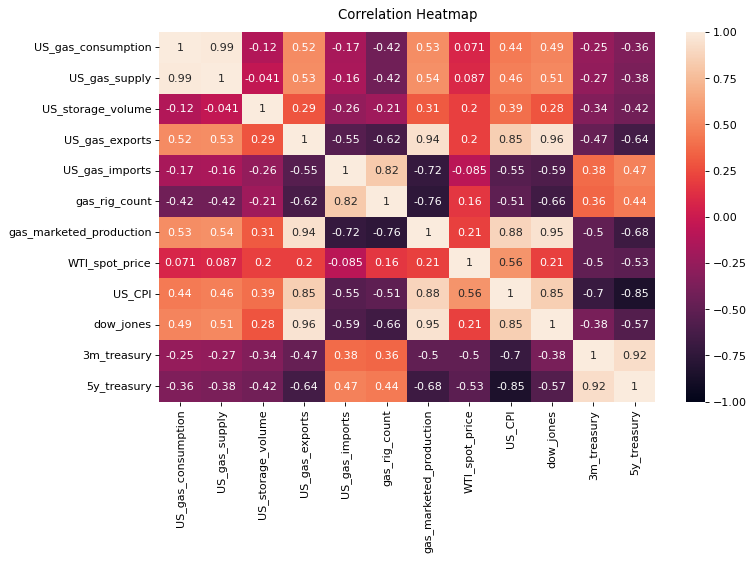

In [167]:
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.show()

### Feature scaling (normalization)

In [168]:
df['HH_spot_price'] = nasdaqdatalink.get('EIA/NG_RNGWHHD_M', start_date='1997-01-07', end_date='2022-01-31')  # current month spot
df['last_month_HH_spot_price'] = df['HH_spot_price'].shift(1)  # one month lagged spot

features += ['HH_spot_price', 'last_month_HH_spot_price']  # new features (autoregressive)
df = df.fillna(method="ffill")
df_norm = (df-df.mean())/df.std()
df_norm

,US_gas_consumption,US_gas_supply,US_storage_volume,US_gas_exports,US_gas_imports,gas_rig_count,gas_marketed_production,WTI_spot_price,US_CPI,dow_jones,3m_treasury,5y_treasury,HH_spot_price,last_month_HH_spot_price
1997-01-31,0.889042,0.995429,-1.232930,-0.910886,-0.166796,-0.401697,-0.780045,-1.106599,-1.673147,-1.147864,1.591447,1.903893,-0.336141,NaN
1997-02-28,0.839795,0.368405,-1.684002,-0.907949,-0.852222,-0.369498,-0.769350,-1.212803,-1.657650,-1.138502,1.621965,1.971512,-0.941884,-0.336239
1997-03-31,0.071668,-0.161538,-1.865343,-0.880819,-0.553666,-0.309702,-0.759528,-1.256365,-1.645253,-1.181112,1.672828,2.195571,-1.063033,-0.941006
1997-04-30,-0.466410,-0.687522,-1.793465,-0.897834,-0.895207,-0.291303,-0.811722,-1.302086,-1.639055,-1.119495,1.637224,2.084401,-0.997799,-1.061959
1997-05-31,-1.006420,-1.223514,-1.405682,-0.924553,-0.830665,-0.256804,-0.795720,-1.261765,-1.642154,-1.072869,1.494808,2.051738,-0.895289,-0.996831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-31,0.611069,0.607943,0.647514,2.993452,-1.207910,-1.271051,2.189461,0.425972,1.874512,2.985900,-0.936438,-1.235221,-0.047248,-0.154809
2021-09-30,0.123091,0.110390,1.134269,2.795341,-1.221585,-1.268751,2.146579,0.568177,1.897539,2.766263,-0.942542,-1.106287,0.460645,-0.047812
2021-10-31,0.244715,0.341599,1.583474,2.862305,-1.076357,-1.273351,2.282233,0.922069,1.968172,3.052339,-0.932369,-0.996836,0.623729,0.459262
2021-11-30,1.302290,1.426483,1.419310,2.946950,-0.818444,-1.266451,2.372679,0.838186,2.010291,2.858907,-0.932369,-1.018611,0.409389,0.622084


### Add the lagged value of the spot price

In [169]:
df_norm['next_month_HH_spot_price'] = nasdaqdatalink.get('EIA/NG_RNGWHHD_M', 
                                                         start_date='1997-01-07', 
                                                         end_date='2022-01-31').shift(-1)

df_norm = df_norm.dropna()

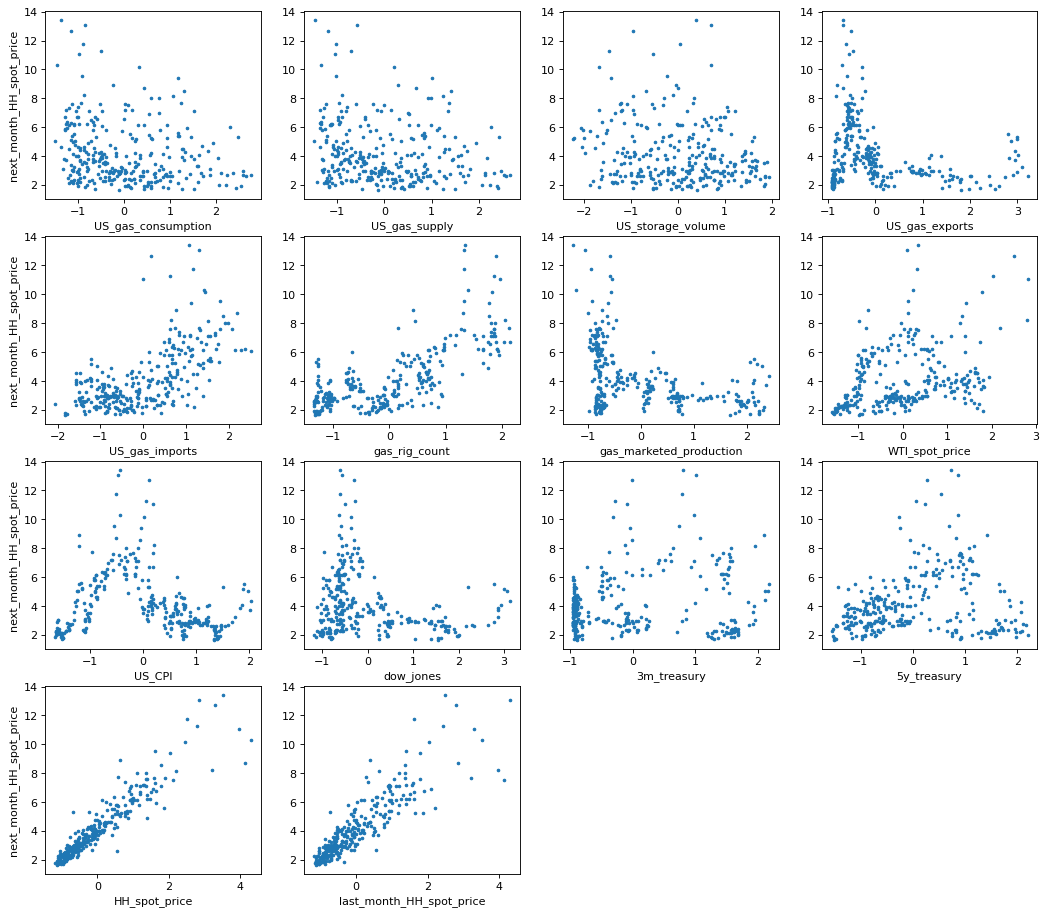

In [170]:
i=1
plt.figure(figsize = (16,14))
for feature in features:
    plt.subplot(4,4,i)
    plt.scatter(df_norm[feature], df_norm['next_month_HH_spot_price'], s=5)
    plt.xlabel(feature)
    if i%4==1: plt.ylabel('next_month_HH_spot_price')
    i += 1
plt.show()

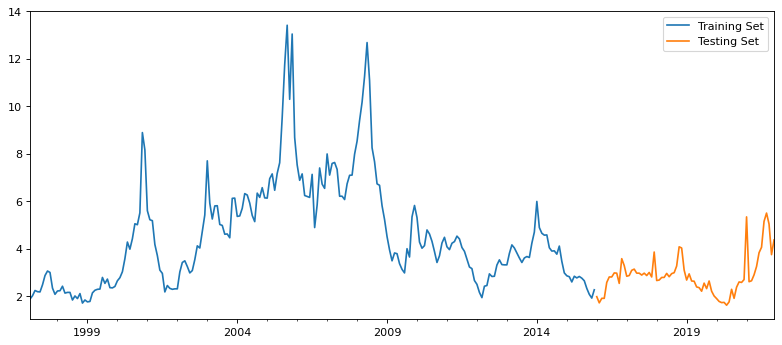

In [370]:
train = df_norm.loc[df_norm.index <= '2015-12-31']
test = df_norm.loc[df_norm.index >= '2016-01-01']

fig, ax = plt.subplots(figsize=(12,5))
train['next_month_HH_spot_price'].plot(ax=ax, label='Training Set')
test['next_month_HH_spot_price'].plot(ax=ax, label='Testing Set')
plt.legend()
plt.show()

In [371]:
X_train, y_train = train.drop('next_month_HH_spot_price', axis=1), train['next_month_HH_spot_price']
X_test, y_test = test.drop('next_month_HH_spot_price', axis=1), test['next_month_HH_spot_price']

## Model #1: Linear Model

#### Least squares

In [172]:
model_ols = LinearRegression()
model_ols.fit(X_train, y_train)
dict(zip(features, model_ols.coef_))

{'US_gas_consumption': -1.0866642830132385,
 'US_gas_supply': 0.9885325852027705,
 'US_storage_volume': -0.149440005062352,
 'US_gas_exports': 1.588778155158432,
 'US_gas_imports': -0.1446514483210315,
 'gas_rig_count': -0.028689539807770725,
 'gas_marketed_production': -1.8524117522871264,
 'WTI_spot_price': 0.06313346402995522,
 'US_CPI': -0.13195741987070597,
 'dow_jones': 0.9514992660078576,
 '3m_treasury': 0.1118132625930974,
 '5y_treasury': -0.1543753890890107,
 'HH_spot_price': 1.745475641472324,
 'last_month_HH_spot_price': 0.03393731835434561}

In [327]:
y_ols_pred_train = pd.DataFrame(model_ols.predict(X_train), index=y_train.index, columns=['next_month_HH_spot_price'])
y_ols_pred_test = pd.DataFrame(model_ols.predict(X_test), index=y_test.index, columns=['OLS forecast'])
print('RMSE train:', np.sqrt(mean_squared_error(y_train, y_ols_pred_train)))
print('RMSE test:', np.sqrt(mean_squared_error(y_test, y_ols_pred_test)))

RMSE train: 0.726698552437614
RMSE test: 2.0014523634161048


#### Ridge regularization

In [328]:
model_ridge = RidgeCV(alphas=np.linspace(.01,1,100))
model_ridge.fit(X_train, y_train)
dict(zip(features, model_ridge.coef_))

{'US_gas_consumption': -0.8216834093871381,
 'US_gas_supply': 0.7348467810642392,
 'US_storage_volume': -0.11385914647864592,
 'US_gas_exports': 1.14833549773657,
 'US_gas_imports': -0.06752338256795398,
 'gas_rig_count': -0.01580776637211978,
 'gas_marketed_production': -1.4547688217967523,
 'WTI_spot_price': 0.08492957368765741,
 'US_CPI': -0.11713246607416694,
 'dow_jones': 0.8045230885939816,
 '3m_treasury': 0.08879957912378866,
 '5y_treasury': -0.1289683037181817,
 'HH_spot_price': 1.7532897986169966,
 'last_month_HH_spot_price': 0.03352118229590717}

In [329]:
y_ridge_pred_train = pd.DataFrame(model_ridge.predict(X_train), index=y_train.index, columns=['next_month_HH_spot_price'])
y_ridge_pred_test = pd.DataFrame(model_ridge.predict(X_test), index=y_test.index, columns=['Ridge forecast'])
print('RMSE train:', np.sqrt(mean_squared_error(y_train, y_ridge_pred_train)))
print('RMSE test:', np.sqrt(mean_squared_error(y_test, y_ridge_pred_test)))

RMSE train: 0.7292765523360142
RMSE test: 1.4784156497100125


#### Lasso regularization

In [330]:
model_lasso = LassoCV(alphas=np.linspace(.01,1,100))
model_lasso.fit(X_train, y_train)
dict(zip(features, model_lasso.coef_))

{'US_gas_consumption': -0.030632408080548946,
 'US_gas_supply': -0.0,
 'US_storage_volume': 0.0,
 'US_gas_exports': 0.0,
 'US_gas_imports': 0.1112541610695761,
 'gas_rig_count': 0.0273759794249642,
 'gas_marketed_production': -0.0,
 'WTI_spot_price': 0.04588118770315367,
 'US_CPI': -0.0,
 'dow_jones': 0.0,
 '3m_treasury': 0.008140201770743878,
 '5y_treasury': 0.0,
 'HH_spot_price': 1.8925735775549033,
 'last_month_HH_spot_price': 0.0}

In [331]:
y_lasso_pred_train = pd.DataFrame(model_lasso.predict(X_train), index=y_train.index, columns=['next_month_HH_spot_price'])
y_lasso_pred_test = pd.DataFrame(model_lasso.predict(X_test), index=y_test.index, columns=['Lasso forecast'])
print('RMSE train:', np.sqrt(mean_squared_error(y_train, y_lasso_pred_train)))
print('RMSE test:', np.sqrt(mean_squared_error(y_test, y_lasso_pred_test)))

RMSE train: 0.7763683142193274
RMSE test: 0.5895031736506094


#### Huber regression

In [332]:
model_huber = HuberRegressor()  # hyperparameter tuning???
model_huber.fit(X_train, y_train)
dict(zip(features, model_huber.coef_))

{'US_gas_consumption': -0.2818206543860821,
 'US_gas_supply': 0.20166908977804263,
 'US_storage_volume': -0.0746806483965868,
 'US_gas_exports': 1.1920448234599195,
 'US_gas_imports': -0.02583807561048742,
 'gas_rig_count': 0.021056132089480085,
 'gas_marketed_production': -1.1931912835445349,
 'WTI_spot_price': 0.04307012485733771,
 'US_CPI': -0.039653179767461286,
 'dow_jones': 0.6916358719283614,
 '3m_treasury': 0.09093214974157672,
 '5y_treasury': -0.039466535421561574,
 'HH_spot_price': 1.9229685696600445,
 'last_month_HH_spot_price': -0.1712242079408002}

In [378]:
y_huber_pred_train = pd.DataFrame(model_huber.predict(X_train), index=y_train.index, columns=['next_month_HH_spot_price'])
y_huber_pred_test = pd.DataFrame(model_huber.predict(X_test), index=y_test.index, columns=['Huber forecast'])
print('RMSE train:', np.sqrt(mean_squared_error(y_train, y_huber_pred_train)))
print('RMSE test:', np.sqrt(mean_squared_error(y_test, y_huber_pred_test)))

RMSE train: 0.8298383329873442
RMSE test: 2.520254456299274


### Plot of all linear models

[]

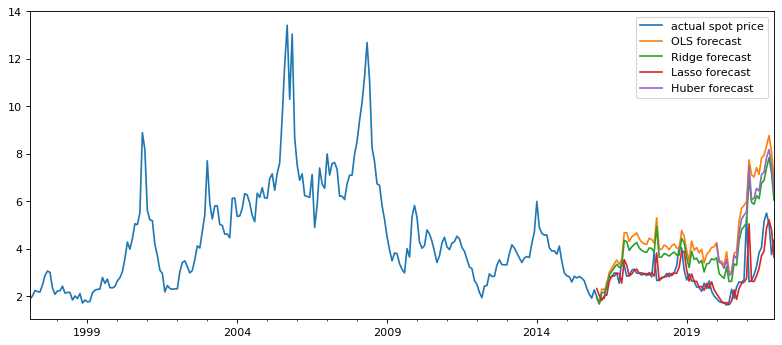

In [379]:
X_all, y_all = df_norm[features], df_norm['next_month_HH_spot_price']
#y_ridge_pred = pd.DataFrame(model_ridge.predict(X_all), index=y_all.index)
#y_lasso_pred = pd.DataFrame(model_lasso.predict(X_all), index=y_all.index)
#y_ols_pred = pd.DataFrame(model_ols.predict(X_all), index=y_all.index)

fig, ax = plt.subplots(figsize=(12,5))
y_all.plot(ax=ax, label='actual spot price')
linear_models_data = [y_ols_pred_test, y_ridge_pred_test, y_lasso_pred_test, y_huber_pred_test]
for linear_model in linear_models_data:
    linear_model.plot(ax=ax)
plt.legend()
plt.plot()

## Model #2: Support Vector Regression

#### Hyper parameter tuning (GridSearch cross-validation)

In [341]:
reg_sv = SVR()
p_grid = {'C':[100,1000,10000], 'kernel':['rbf', 'poly']}
search = GridSearchCV(estimator=reg_sv, param_grid=p_grid)
search.fit(X_train, y_train.ravel())
sv_preds = search.best_estimator_
y_SVR_pred_train = sv_preds.predict(X_train)
y_SVR_pred_test = pd.DataFrame(sv_preds.predict(X_test), index=X_test.index, columns=['SVR forecast'])
print('RMSE train:', np.sqrt(mean_squared_error(y_train, y_SVR_pred_train)))
print('RMSE test:', np.sqrt(mean_squared_error(y_test, y_SVR_pred_test)))

RMSE train: 0.09406978818613407
RMSE test: 0.9765765944220287


[]

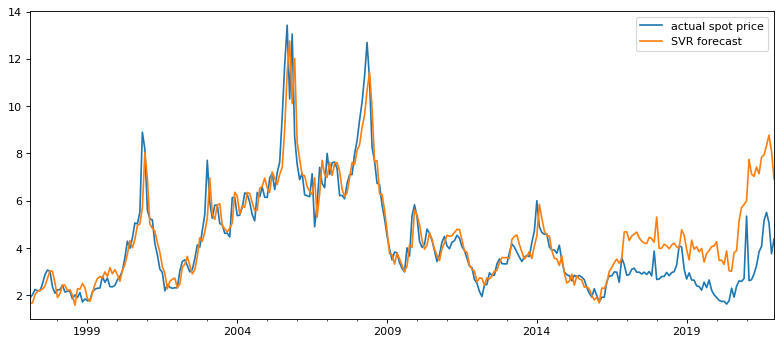

In [343]:
X_all, y_all = df_norm[features], df_norm['next_month_HH_spot_price']
y_SVR_pred = pd.DataFrame(model_ols.predict(X_all), index=y_all.index, columns=['SVR forecast'])

fig, ax = plt.subplots(figsize=(12,5))
y_all.plot(ax=ax, label='actual spot price')
y_SVR_pred.plot(ax=ax, label='SVR forecast')

plt.legend()
plt.plot()

## Model #3: Decision Trees

#### Regression tree

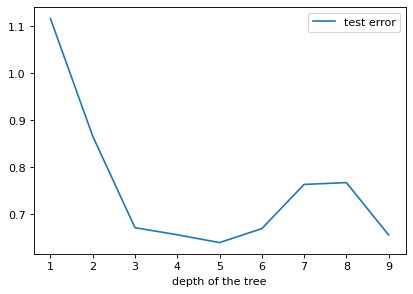

In [221]:
errors=[]
for depth in range(1,10):
    tree = DecisionTreeRegressor(max_depth=depth)
    tree.fit(X_train, y_train)
    y_tree_pred_test = pd.DataFrame(tree.predict(X_test), index=y_test.index, columns=['HH_predicted_spot'])
    errors += [np.sqrt(mean_squared_error(y_test, y_tree_pred_test))]
plt.figure(figsize=(6,4))
plt.plot(range(1,10), errors, label='test error')
plt.xlabel('depth of the tree')
plt.legend()
plt.show()

In [186]:
model_tree = DecisionTreeRegressor(max_depth=5)
model_tree.fit(X_train, y_train)
dict(zip(features, model_tree.feature_importances_))

{'US_gas_consumption': 0.0,
 'US_gas_supply': 0.0,
 'US_storage_volume': 0.0,
 'US_gas_exports': 0.0,
 'US_gas_imports': 0.011839755262891,
 'gas_rig_count': 0.011835950406428,
 'gas_marketed_production': 0.003641924285582863,
 'WTI_spot_price': 0.0008767942841004452,
 'US_CPI': 0.0033730804638797893,
 'dow_jones': 0.0,
 '3m_treasury': 0.03014707446745715,
 '5y_treasury': 0.003673057336218249,
 'HH_spot_price': 0.9346123634934426,
 'last_month_HH_spot_price': 0.0}

In [187]:
y_tree_pred_train = pd.DataFrame(model_tree.predict(X_train), index=y_train.index, columns=['HH_predicted_spot'])
y_tree_pred_test = pd.DataFrame(model_tree.predict(X_test), index=y_test.index, columns=['HH_predicted_spot'])
print('RMSE train:', np.sqrt(mean_squared_error(y_train, y_tree_pred_train)))
print('RMSE test:', np.sqrt(mean_squared_error(y_test, y_tree_pred_test)))

RMSE train: 0.419079955290755
RMSE test: 0.6392714164044653


In [190]:
cross_val_score(model_tree, X_test, y_test,
                scoring="accuracy", 
                cv=5).mean()

nan

#### Bagged tree (Random Forrest)

#### Boosted tree (XGBoost)

In [372]:
# XGBoost w/ timeseriessplit (cross-validation)
tss = TimeSeriesSplit(n_splits=5, test_size=24)

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df_norm):
    print('Fold', fold)
    train = df_norm.iloc[train_idx]
    test = df_norm.iloc[val_idx]

    X_train = train[features]
    y_train = train['next_month_HH_spot_price']

    X_test = test[features]
    y_test = test['next_month_HH_spot_price']

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=200)
    
    fold += 1
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

Fold 0
[0]	validation_0-rmse:4.98499	validation_1-rmse:2.87545
[200]	validation_0-rmse:0.93030	validation_1-rmse:0.49251
[389]	validation_0-rmse:0.42049	validation_1-rmse:0.35536
Fold 1
[0]	validation_0-rmse:4.78444	validation_1-rmse:3.04991
[200]	validation_0-rmse:0.89131	validation_1-rmse:0.53710
[388]	validation_0-rmse:0.41052	validation_1-rmse:0.40507
Fold 2
[0]	validation_0-rmse:4.63196	validation_1-rmse:2.34665
[200]	validation_0-rmse:0.86386	validation_1-rmse:0.51569
[400]	validation_0-rmse:0.40218	validation_1-rmse:0.41633
[445]	validation_0-rmse:0.37650	validation_1-rmse:0.41674
Fold 3
[0]	validation_0-rmse:4.46429	validation_1-rmse:2.31658
[200]	validation_0-rmse:0.83627	validation_1-rmse:0.45163
[324]	validation_0-rmse:0.47550	validation_1-rmse:0.41130
Fold 4
[0]	validation_0-rmse:4.31964	validation_1-rmse:2.82609
[200]	validation_0-rmse:0.80950	validation_1-rmse:0.98926
[400]	validation_0-rmse:0.39270	validation_1-rmse:0.90580
[436]	validation_0-rmse:0.37352	validation_1-rm

In [373]:
print('RMSE test:', np.mean(scores))
print('k-folds RMSE test:', np.round(scores,6))

RMSE test: 0.49354278870974894
k-folds RMSE test: [0.341674 0.401713 0.415836 0.403972 0.90452 ]


In [374]:
import xgboost as xgb  # conda install xgboost

xgboost_tree = xgb.XGBRegressor(n_estimators=500)
xgboost_tree.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)
dict(zip(features, xgboost_tree.feature_importances_))

{'US_gas_consumption': 0.002050942,
 'US_gas_supply': 0.0021349373,
 'US_storage_volume': 0.001481976,
 'US_gas_exports': 0.0049127834,
 'US_gas_imports': 0.004585294,
 'gas_rig_count': 0.046948183,
 'gas_marketed_production': 0.0033360342,
 'WTI_spot_price': 0.0021394703,
 'US_CPI': 0.0016359854,
 'dow_jones': 0.002749959,
 '3m_treasury': 0.009550307,
 '5y_treasury': 0.0058675176,
 'HH_spot_price': 0.9067615,
 'last_month_HH_spot_price': 0.005845017}

In [375]:
y_xgb_pred_train = pd.DataFrame(xgboost_tree.predict(X_train), index=y_train.index, columns=['HH_predicted_spot'])
y_xgb_pred_test = pd.DataFrame(xgboost_tree.predict(X_test), index=y_test.index, columns=['XGBoost prediction'])

print('RMSE train:', np.sqrt(mean_squared_error(y_train, y_xgb_pred_train)))
print('RMSE test:', np.sqrt(mean_squared_error(y_test, y_xgb_pred_test)))

RMSE train: 0.0009677933691142279
RMSE test: 1.0628126152484012


[]

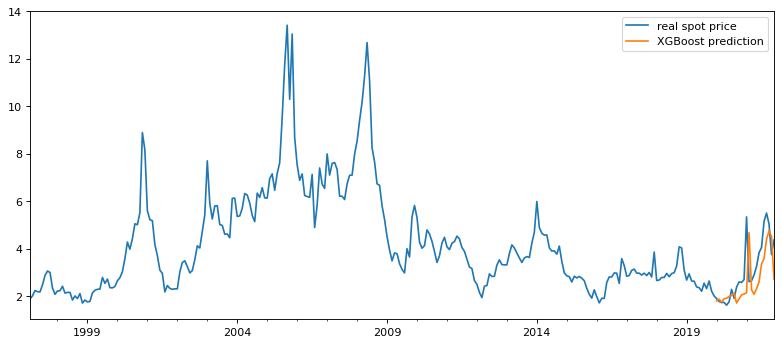

In [376]:
fig, ax = plt.subplots(figsize=(12,5))
y_all.plot(ax=ax, label='real spot price')
y_xgb_pred_test.plot(ax=ax)
plt.legend()
plt.plot()

RMSE: 0.7592496697471772


[]

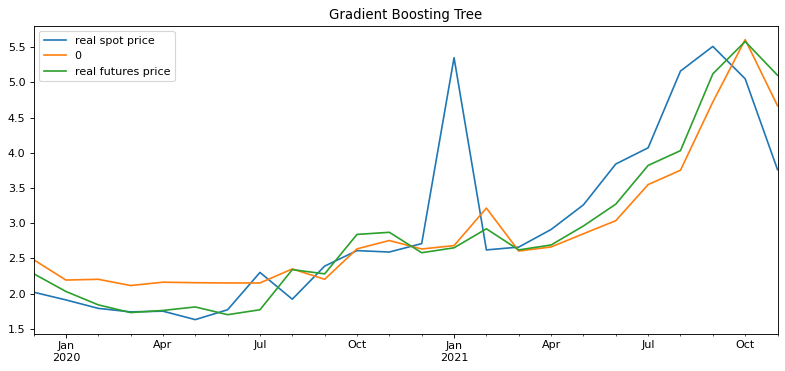

In [711]:
y_kxgb_pred = pd.DataFrame(reg.predict(X_test), index=y_test.index)
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_kxgb_pred)))
fig, ax = plt.subplots(figsize=(12,5))
y_test.plot(ax=ax, label='real spot price')
y_kxgb_pred.plot(ax=ax, label='forecasted spot price')
X_test['gas_futures_1'].plot(ax=ax, label='real futures price')
plt.title('Gradient Boosting Tree')
plt.legend()
plt.plot()

In [648]:
dict(zip(features, reg.feature_importances_))

{'US_gas_consumption': 0.0020116407,
 'US_gas_supply': 0.0018308125,
 'US_storage_volume': 0.0054682745,
 'US_gas_exports': 0.004528886,
 'US_gas_imports': 0.0016872108,
 'WTI_spot_price': 0.0035026118,
 'gas_futures_1': 0.8809996,
 'US_CPI': 0.0018014587,
 'dow_jones': 0.010058801,
 '3m_treasury': 0.0018436576,
 '5y_treasury': 0.0013507361,
 'lag_1m': 0.074790224,
 'lag_2m': 0.007979269,
 'lag_3m': 0.0021467733}

## Model #4: Autoregressive models

#### Test of stationarity (Augmented Dickey-Fuller test)

In [259]:
adfuller(df_norm['next_month_HH_spot_price'])  # H0: ts is non-stationary

(-3.18756603629313,
 0.02071578163306949,
 0,
 298,
 {'1%': -3.4524859843440754,
  '5%': -2.871288184343229,
  '10%': -2.571964047565425},
 652.7316427372062)

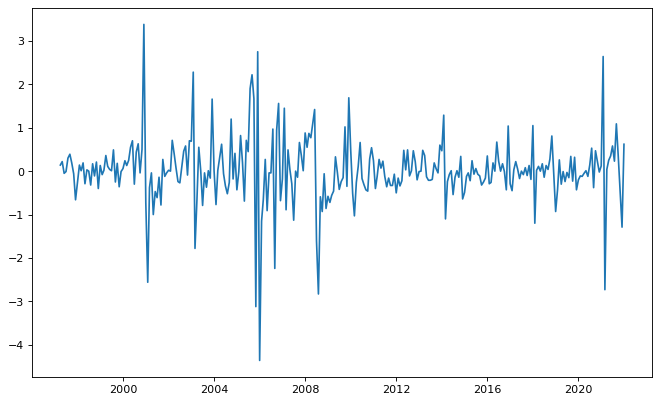

In [284]:
plt.plot(df_norm['next_month_HH_spot_price']-df_norm['next_month_HH_spot_price'].shift(1))

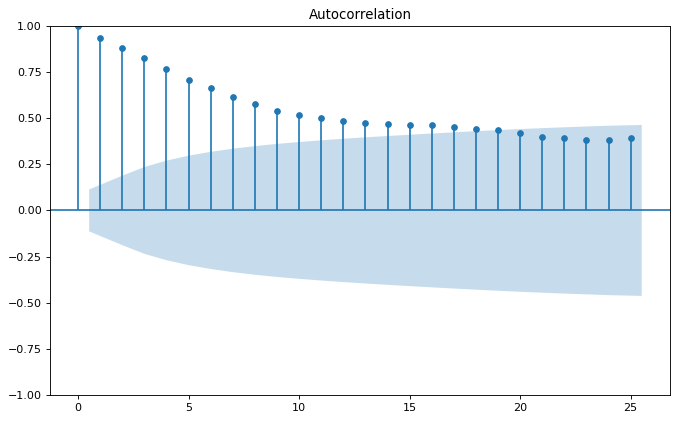

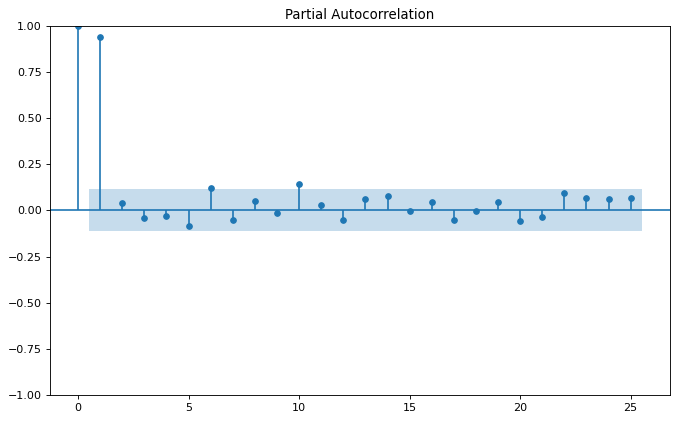

In [260]:
plot_acf(df_norm['next_month_HH_spot_price'])
plot_pacf(df_norm['next_month_HH_spot_price'])
plt.show()

In [288]:
garch = arch_model(df_norm['next_month_HH_spot_price'], vol='garch', p=1, o=0, q=0)
garch_fitted = garch.fit()
#garch_fitted.plot()
garch_fitted.summary()
#garch_forecast = garch_fitted.forecast(horizon=12)

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1749.5299594580165
Iteration:      2,   Func. Count:     13,   Neg. LLF: 13849.299995893858
Iteration:      3,   Func. Count:     18,   Neg. LLF: 12534.456469074144
Iteration:      4,   Func. Count:     23,   Neg. LLF: 44460.63282495586
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4628.045040328321
Iteration:      6,   Func. Count:     33,   Neg. LLF: 552.7118873096381
Iteration:      7,   Func. Count:     38,   Neg. LLF: 673.4791531424921
Iteration:      8,   Func. Count:     43,   Neg. LLF: 920.6174312924568
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4760.14775598483
Iteration:     10,   Func. Count:     53,   Neg. LLF: 19587.720247367717
Iteration:     11,   Func. Count:     58,   Neg. LLF: 54800.88910541268
Iteration:     12,   Func. Count:     63,   Neg. LLF: 12439.147426243384
Iteration:     13,   Func. Count:     68,   Neg. LLF: 9972.352490145651
Iteration:     14,   Func. Count:     73,   Neg. LLF: 527.14

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Constant Mean - ARCH Model Results                         
====================================================================================
Dep. Variable:     next_month_HH_spot_price   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                             ARCH   Log-Likelihood:               -477.405
Distribution:                        Normal   AIC:                           960.810
Method:                  Maximum Likelihood   BIC:                           971.911
                                              No. Observations:                  299
Date:                      Tue, May 09 2023   Df Residuals:                      298
Time:                              13:34:07   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             3.0250      0.132     22.866 1.010e-115 [  2.766,  3.284]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1543  4.631e-02      3.332  8.624e-04 [6.354e-02,  0.245]
alpha[1]       1.0000  6.919e-02     14.453  2.384e-47   [  0.864,  1.136]
==========================================================================

Covariance estimator: robust
"""

## APPENDIX

#### Unit mapping of the features

In [104]:
features_units_mapping = {
    'HH_spot_price':'USD/MMBtu',
    'US_gas_consumption':'bcf/day',
    'US_gas_supply':'bcf/day',
    'US_storage_volume':'MMcf',
    'US_gas_exports':'MMcf',
    'US_gas_imports':'MMcf',
    'gas_futures_1':'USD/MMBtu',
    'WTI_spot_price':'USD/barrel',
    'TTF_spot_price':'EUR/MWh',
}

#### K-fold cross validation for time series

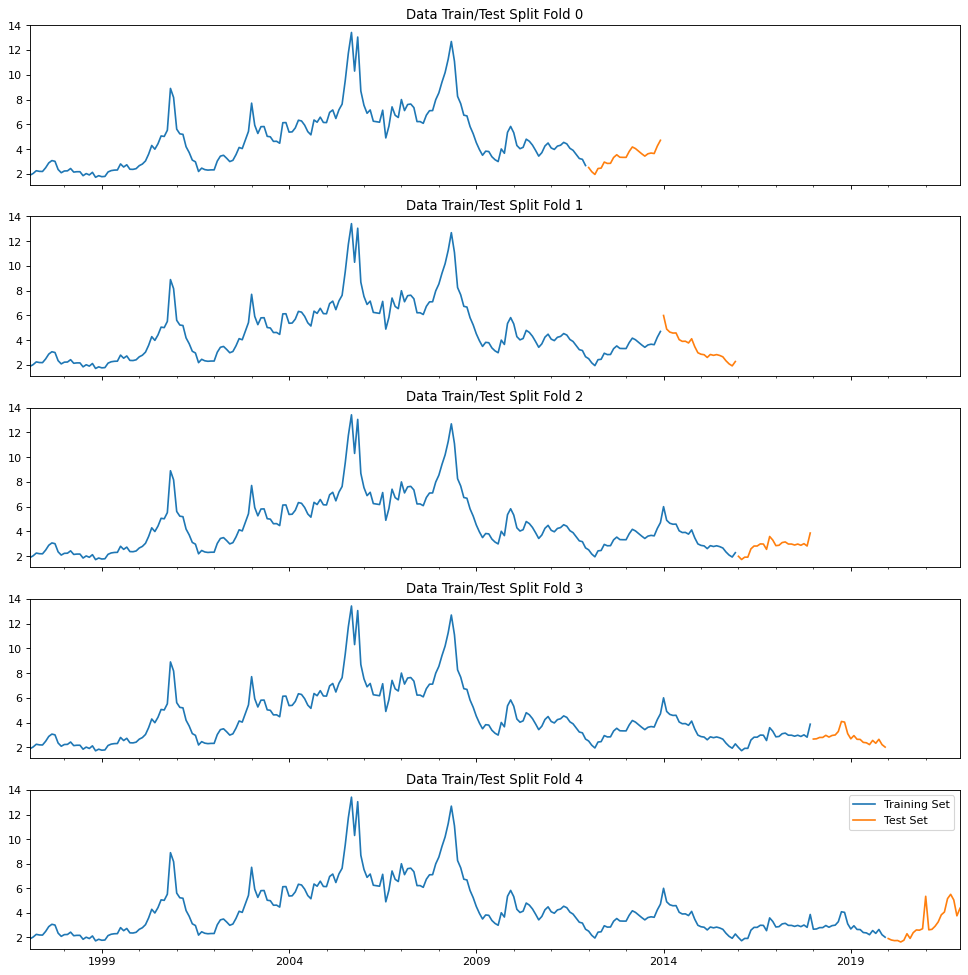

In [295]:
tss = TimeSeriesSplit(n_splits=5, test_size=24)

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df_norm):
    train = df_norm.iloc[train_idx]
    test = df_norm.iloc[val_idx]
    train['next_month_HH_spot_price'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['next_month_HH_spot_price'].plot(ax=axs[fold],
                         label='Test Set')
    fold += 1
plt.legend()
plt.show()


In [63]:
train = ts.loc[ts.index <= '2016-12-31']
test = ts.loc[ts.index >= '2017-01-01']
arima_model = auto_arima(train, start_p=0, d=None, start_q=0, max_p=5, max_d=5, max_q=5)
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  239
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -277.666
Date:                Fri, 05 May 2023   AIC                            561.332
Time:                        14:26:17   BIC                            571.761
Sample:                    02-28-1997   HQIC                           565.534
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9810      0.026    -38.437      0.000      -1.031      -0.931
ma.L1          0.9507      0.039     24.374      0.000       0.874       1.027
sigma2         0.5973      0.028     21.593      0.000       0.543       0.652
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):               460.08
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               0.30   Skew:                             0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""